<a href="https://colab.research.google.com/github/Edimer/My_CloudComputing/blob/master/S14AirQo_Uganda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[AirQo Ugandan Air Quality Forecast Challenge](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge)
===========================================
### Modelos XGBoost con H2o en R

[Edimer David Jaramillo ](https://edimer.github.io/)  
Abril de 2020

## Instalación de H2o y carga de bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
library(h2o)
library(tidyverse)

## Cargando datos

In [0]:
load("/content/dataTest_Originales.Rdata")
load("/content/dataTrain_Originales.Rdata")

## Distribución de variable respuesta

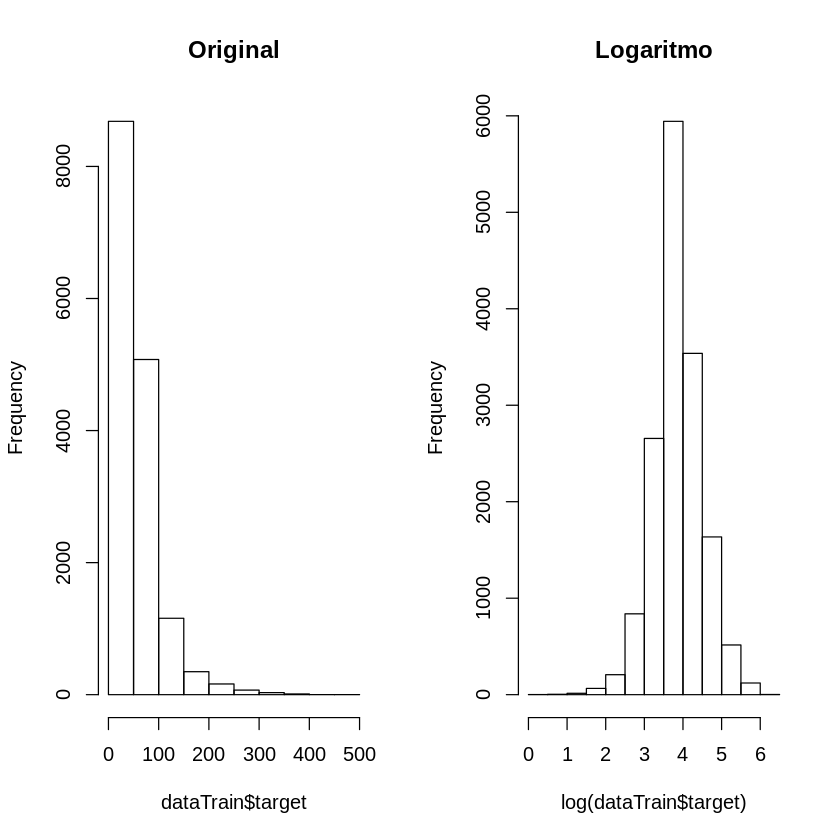

In [7]:
par(mfrow = c(1, 2))
hist(dataTrain$target, main = "Original")
hist(log(dataTrain$target), main = "Logaritmo")

## Preparación de datos

In [28]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# df_train y df_test
df_train <- dataTrain %>% 
  select(-ID) %>%
  #mutate(target = log(target)) %>%
  mutate_at(vars(T1:T121, WS1:WS121), log)

datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")
particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.7, 0.20),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Variable respuesta y predictores
var_respuesta <- "target"
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 hours 56 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    12 days  
    H2O cluster name:           H2O_started_from_R_root_uzf880 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   9.86 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 

  |======================================================================| 100%


## Modelo XGBoost

In [29]:
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb1"
                  ,stopping_rounds = 50
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"
                  ,score_tree_interval = 1
                  ,learn_rate=0.1
                  ,ntrees=10000
                  ,subsample = 0.9
                  ,colsample_bytree = 0.7
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0 #default
                  ,nfolds = 10
                  ,seed = 123
                  ,max_depth = 0 #without limit
                  ,min_rows = 50 #alias min_child_weight
                  ,max_leaves = 350
                  ,max_bins = 256 #(default)
                  ,min_sum_hessian_in_leaf = 100
                  ,max_runtime_secs = 3600)

Warning message in .h2o.processResponseWarnings(res):
“Dropping bad and constant columns: [precMinTotal].
”


  |======================================================================| 100%


## Resultados del modelo XGBoost

In [30]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb1 
Model Summary: 
  number_of_trees
1             193


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  27.69131
RMSE:  5.262253
MAE:  2.128996
RMSLE:  0.05811625
Mean Residual Deviance :  27.69131


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  618.8964
RMSE:  24.87763
MAE:  15.19746
RMSLE:  0.354188
Mean Residual Deviance :  618.8964


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  659.9888
RMSE:  25.69025
MAE:  15.77919
RMSLE:  0.3615603
Mean Residual Deviance :  659.9888


Cross-Validation Metrics Summary: 
                             mean          sd cv_1_valid cv_2_valid cv_3_valid
mae                     15.790663  0.43859285  15.443479  15.668994  15.542156
mean_residual_deviance  662.16003    92.46221   635.5646  649.37274   550.5044
mse     

## Predicciones

In [35]:
# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(dataTest)) %>%
  as.data.frame() %>% pull(predict)

dataTest %>% 
  select(ID) %>% 
  mutate(target = predichos_subm) ->
  subm14

# Exportando predicciones
write.csv(subm14, file = "subm14.csv", row.names = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## RMSE Train y Test (train)

In [36]:
# Función
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

data,RMSE
<fct>,<dbl>
Train,5.262253
Test,25.306832


## Importancia de variables

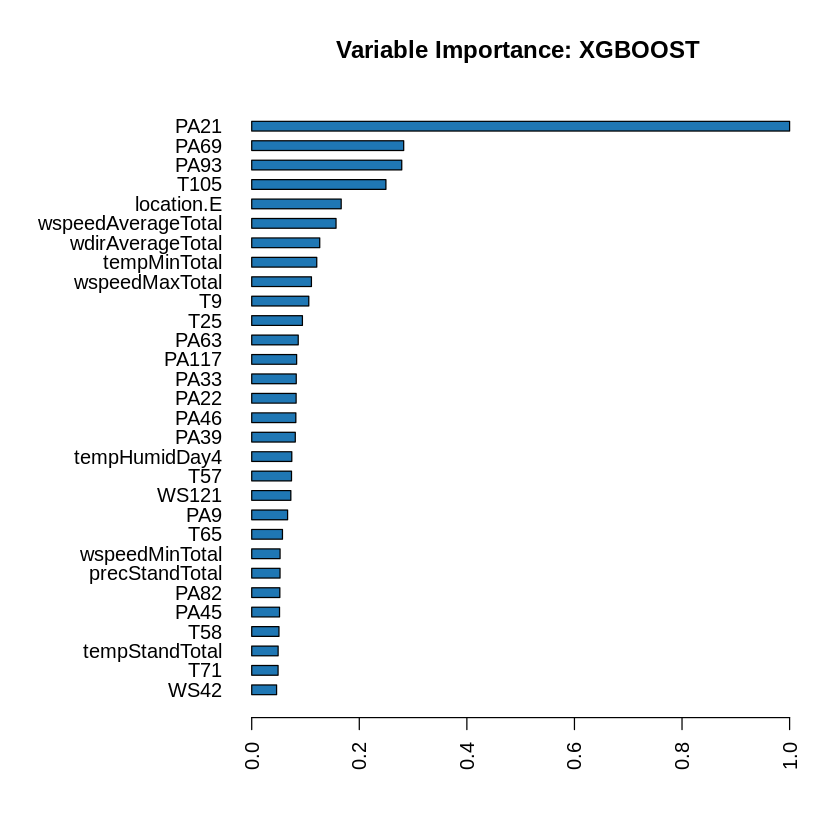

In [37]:
h2o.varimp_plot(xgb, num_of_features = 30)

## Guardando modelo

In [38]:
h2o.saveModel(xgb, path = "XGB_S14", force = TRUE)

[1] "/content/XGB_S14/xgb1"